# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Nonlinear Ops --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. 

There are three notebooks in this series:

1. *Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops*
[ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)
<br>Implement the nonlinear modeling operations. 

2. *Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops*
[ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)
<br>Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.

3. *Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing*
[ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)
<br>Tests the correctness of the implemented operators.

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we introduce the *skew self adjoint* form of the scalar isotropic variable density visco- acoustic wave equation with a simple form of dissipation only Q attenuation. This dissipation only (no dispersion) attenuation term $\left (\frac{\displaystyle \omega}{Q} \partial_t u \right)$ is an approximation of a [Maxwell Body](https://en.wikipedia.org/wiki/Maxwell_material) -- that is to say viscoelasticity approximated with a spring and dashpot in series. In practice this approach for attentuating outgoing waves is very similar to the Cerjan style damping in absorbing boundaries used elsewhere in Devito ([References](#nl_refs)). 

The derivation of the attenuation model is not in scope for this tutorial, but one important point is that the physics in the absorbing boundary region and the interior of the model are *unified*, allowing the same modeling equations to be used everwhere, with physical Q values in the interior tapering to small Q at the boundaries to attentuate outgoing waves. 

## Outline 
1. Define symbols [[link]](#nl_symbols) 
2. Introduce the SSA wave equation [[link]](#nl_we) 
3. Show generation of skew symmetric derivatives and prove correctness with unit test [[link]](#nl_ssa_derivs) 
4. Derive the time update equation used to implement the nonlinear forward modeling operator [[link]](#nl_time_update) 
5. Create the Devito grid and model fields [[link]](#nl_grid_and_model) 
6. Define a function to implement the attenuation profile ($\omega\ /\ Q$) [[link]](#nl_attenuation) 
7. Create the Devito operator [[link]](#nl_build_operator) 
8. Run the Devito operator [[link]](#nl_run_operator) 
9. Plot the resulting wavefields [[link]](#nl_plot_wavefield) 
10. References [[link]](#nl_refs) 

<a id="nl_symbols"></a>
## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
| :---         | :---              | :--- |
| $\omega_c = 2 \pi f_c$ | center angular frequency | constant |
| $m(x,y,z)$   | P wave velocity    | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $u(t,x,y,z)$ | Pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source term        | function of time, localized in space |
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x} u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z} u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t} u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

<a id="nl_we"></a>
## SSA variable density visco- acoustic wave equation

Our skew self adjoint wave equation is written:

$$
\frac{b}{m^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ u + \partial_{tt}\ u \right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + s 
$$

An advantage of this form is that the same system can be used to provide *unconditionally stable* modes of propagation for all operations needed in quasi- Newton optimization: 

- the nonlinear forward 
- the linearized forward (Jacobian forward)
- the linearized adjoint (Jacobian adjoint)

This advantage is more important for anisotropic operators, where widely utilized non energy conserving formulations can provide unstable adjoints and thus unstable gradients for anisotropy parameters.  

The *skew self adjoint* formulation is evident in the shifted spatial derivatves, with the derivative on the right side $\overrightarrow{\partial}$ shifting forward in space one-half cell, and the derivative on the left side $\overleftarrow{\partial}$ shifting backward in space one-half cell. 

$\overrightarrow{\partial}$ and $\overleftarrow{\partial}$ are anti-symmetric (also known as skew symmetric), meaning that for two random vectors $x_1$ and $x_2$, correctly implementated numerical derivatives will have the following property:

$$
x_2 \cdot \left( \overrightarrow{\partial_x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial_x}\ x_2 \right) 
$$

Below we will demonstrate this skew symmetry with a simple unit test on Devito generated derivatives. 

In the following notebooks in this series, material parameters *sandwiched* between the derivatives -- including anisotropy parameters -- become much more interesting, but here buoyancy $b$ is the only material parameter in the right hand side of our skew self adjoint (SSA) wave equation. 

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'

<a id="nl_ssa_derivs"></a>
## Unit test demonstrating skew symmetry for shifted derivatives

As noted above, we prove with a small 1D unit test and 8th order spatial operator that the Devito shifted first derivatives are skew symmetric. This anti-symmetry can demonstrated for the forward and backward half cell shift first derivative operators $\overrightarrow{\partial}$ and $\overleftarrow{\partial}$ with two random vectors $x_1$ and $x_2$ by verifying the *dot product test* as written above.

We will use Devito to implement the following two equations with an ```Operator```:

$$
\begin{aligned}
f_2 = \overrightarrow{\partial_x}\ f_1 \\[5pt]
g_2 = \overleftarrow{\partial_x}\ g_1
\end{aligned}
$$

And then verify the dot products are equivalent:  

$$
f_1 \cdot g_2 \approx g_1 \cdot f_2
$$

We use the following test for relative error (note the flipped signs in numerator and denominator due to anti- symmetry):

$$
\frac{\displaystyle f_1 \cdot g_2 + g_1 \cdot f_2}
     {\displaystyle f_1 \cdot g_2 - g_1 \cdot f_2}\ <\ \epsilon
$$


In [2]:
#NBVAL_INGNORE_OUTPUT
# Make 1D grid to test derivatives 
n = 101
d = 1.0
shape = (n, )
spacing = (1 / (n-1), )   
origin = (0., )
extent = (d * (n-1), )
dtype = np.float32

# Initialize Devito grid and Functions for input(f1,g1) and output(f2,g2)
grid1d = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x = grid1d.dimensions[0]
f1 = Function(name='f1', grid=grid1d, space_order=8)
f2 = Function(name='f2', grid=grid1d, space_order=8)
g1 = Function(name='g1', grid=grid1d, space_order=8)
g2 = Function(name='g2', grid=grid1d, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
f1.data[:] = -1 + 2 * np.random.rand(n,)
g1.data[:] = -1 + 2 * np.random.rand(n,)

# Equation defining: [f2 = forward 1/2 cell shift derivative applied to f1]
equation_f2 = Eq(f2, f1.dx(x0=x+0.5*x.spacing))

# Equation defining: [g2 = backward 1/2 cell shift derivative applied to g1]
equation_g2 = Eq(g2, g1.dx(x0=x-0.5*x.spacing))

# Define an Operator to implement these equations and execute
op = Operator([equation_f2, equation_g2])
op()

# Compute the dot products and the relative error
f1g2 = np.dot(f1.data, g2.data)
g1f2 = np.dot(g1.data, f2.data)
diff = (f1g2+g1f2)/(f1g2-g1f2)

tol = 100 * np.finfo(np.float32).eps
print("f1g2, g1f2, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (f1g2, g1f2, diff, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert diff < 100 * np.finfo(np.float32).eps

Allocating memory for f1(117,)
Allocating memory for g1(117,)
Operator `Kernel` generated in 0.15 s
  * lowering.Expressions: 0.09 s (61.5 %)
  * lowering.IET: 0.03 s (20.5 %)
     * specializing.IET: 0.03 s (20.5 %)
  * lowering.Clusters: 0.03 s (20.5 %)
     * specializing.Clusters: 0.03 s (20.5 %)
Flops reduction after symbolic optimization: [62 --> 25]
Allocating memory for f2(117,)
Allocating memory for g2(117,)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/8a11eb4be1534b4bdb8640c8c4100d243ec05e3f.c` in 0.12 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0<101> with OI=1.51 computed in 0.01 s [0.01 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


f1g2, g1f2, diff, tol; +6.167917e+00 -6.167917e+00 -3.865463e-08 +1.192093e-05


In [3]:
#NBVAL_INGNORE_OUTPUT
# Make 1D grid to test derivatives 
dtype = np.float32
n = 101
d = 1.0
shape = (n, )
spacing = (1 / (n-1), )   
origin = (0., )
extent = (d * (n-1), )

# Initialize Devito grid and Functions for input(f1,g1) and output(f2,g2)
grid1d = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x = grid1d.dimensions[0]
f1 = Function(name='f1', grid=grid1d, space_order=8)
f2 = Function(name='f2', grid=grid1d, space_order=8)
g1 = Function(name='g1', grid=grid1d, space_order=8)
g2 = Function(name='g2', grid=grid1d, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
f1.data[:] = -1 + 2 * np.random.rand(n,)
g1.data[:] = -1 + 2 * np.random.rand(n,)

# Equation defining: [f2 = forward 1/2 cell shift derivative applied to f1]
equation_f2 = Eq(f2, f1.dx(x0=x+0.5*x.spacing))

# Equation defining: [g2 = backward 1/2 cell shift derivative applied to g1]
equation_g2 = Eq(g2, g1.dx(x0=x-0.5*x.spacing))

# Define an Operator to implement these equations and execute
op = Operator([equation_f2, equation_g2])
op()

# Compute the dot products and the relative error
f1g2 = np.dot(f1.data, g2.data)
g1f2 = np.dot(g1.data, f2.data)
diff = (f1g2+g1f2)/(f1g2-g1f2)

tol = 100 * np.finfo(np.float32).eps
print("f1g2, g1f2, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (f1g2, g1f2, diff, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert diff < 100 * np.finfo(np.float32).eps

Allocating memory for f1(117,)
Allocating memory for g1(117,)
Operator `Kernel` generated in 0.14 s
  * lowering.Expressions: 0.08 s (57.6 %)
  * lowering.IET: 0.03 s (21.6 %)
     * specializing.IET: 0.03 s (21.6 %)
  * lowering.Clusters: 0.03 s (21.6 %)
     * specializing.Clusters: 0.03 s (21.6 %)
Flops reduction after symbolic optimization: [62 --> 25]
Allocating memory for f2(117,)
Allocating memory for g2(117,)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/8a11eb4be1534b4bdb8640c8c4100d243ec05e3f.c` in 0.03 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0<101> with OI=1.51 computed in 0.01 s [0.01 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


f1g2, g1f2, diff, tol; -2.527510e+00 +2.527511e+00 -9.432941e-08 +1.192093e-05


## Show the finite difference operators and generated code

You can inspect the finite difference coefficients and locations for evaluation with the code shown below. 

For your reference, the finite difference coefficients seen in the first two stanzas below are exactly the coefficients generated in Table 2 of Fornberg's paper **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** linked below ([References](#nl_refs)).

Note that you don't need to inspect the generated code, but this does provide the option to use this highly optimized code in applications that do not need or require python.

In [4]:
#NBVAL_INGNORE_OUTPUT

# Show the FD coefficients generated by Devito 
# for the forward 1/2 cell shifted first derivative operator
print("\n\nForward +1/2 cell shift;")
print("..................................")
print(f1.dx(x0=x+0.5*x.spacing).evaluate)

# Show the FD coefficients generated by Devito 
# for the backward 1/2 cell shifted first derivative operator
print("\n\nBackward -1/2 cell shift;")
print("..................................")
print(f1.dx(x0=x-0.5*x.spacing).evaluate)

# Show code generated by Devito for applying the derivatives
print("\n\nGenerated c++ code;")
print("..................................")
print(op.ccode)



Forward +1/2 cell shift;
..................................
-1.19628906*f1(x)/h_x + 0.000697544643*f1(x - 3.0*h_x)/h_x - 0.0095703125*f1(x - 2.0*h_x)/h_x + 0.0797526042*f1(x - 1.0*h_x)/h_x + 1.19628906*f1(x + 1.0*h_x)/h_x - 0.0797526042*f1(x + 2.0*h_x)/h_x + 0.0095703125*f1(x + 3.0*h_x)/h_x - 0.000697544643*f1(x + 4.0*h_x)/h_x


Backward -1/2 cell shift;
..................................
1.19628906*f1(x)/h_x + 0.000697544643*f1(x - 4.0*h_x)/h_x - 0.0095703125*f1(x - 3.0*h_x)/h_x + 0.0797526042*f1(x - 2.0*h_x)/h_x - 1.19628906*f1(x - 1.0*h_x)/h_x - 0.0797526042*f1(x + 1.0*h_x)/h_x + 0.0095703125*f1(x + 2.0*h_x)/h_x - 0.000697544643*f1(x + 3.0*h_x)/h_x


Generated c++ code;
..................................
#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oof

<a id="nl_time_update"></a>
## Doing some algebra to solve for the time update

The next step in implementing our Devito modeling operator is to define the equation used to update the pressure wavefield as a function of time. What follows is a bit of algebra using the wave equation and finite difference approximations to time derivatives to express the pressure wavefield forward in time $u(t+\delta t)$ as a function of the current $u(t)$ and previous $u(t-\delta t)$ pressure wavefields.

#### 1. Numerical approximation for $\partial_{tt}\ u$
The second order accurate centered approximation to the second time derivative involves three wavefields: $u(t-\delta t)$, $u(t)$, and $u(t+\delta t)$. 

$$
\partial_{tt} u = \frac{\displaystyle u(t+\delta t) - 2\ u(t) + u(t-\delta t)}{\displaystyle \delta t^2} 
$$

#### 2. Solve equation for $u(t+\delta t)$
In order to advance our finite difference solution in time, we solve for $u(t+\delta t)$.

$$
u(t+\delta t) = \delta t^2 \partial_{tt} u 
    + 2\ u(t) - u(t-\delta t)
$$

#### 3. Numerical approximation for $\overleftarrow{\partial_{t}}\ u$
The argument for using a backward approximation is a bit hand wavy, but goes like this: a centered or forward approximation for $\partial_{t}u$ would involve the term $u(t+\delta t)$, and hence $u(t+\delta t)$ would appear at two places in our time update equation below, essentially making the form implicit (although it would be easy to solve for $u(t+\delta t)$). 

We are interested in explicit time stepping and the correct behavior of the attenuation term, and so prefer the backward approximation for $\overleftarrow{\partial_{t}}\ u$. Our experience is that the use of the backward difference is more stable than forward or centered.

The first order accurate backward approximation to the first time derivative involves two wavefields: $u(t-\delta t)$, and $u(t)$. We can use this expression as is. 

$$
\overleftarrow{\partial_{t}}\ u = \frac{\displaystyle u(t) - u(t-\delta t)}{\displaystyle \delta t}
$$

#### 4. Solve the wave equation for $\partial_{tt}$

$$
\begin{aligned}
\frac{b}{m^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_{t}}\ u +
    \partial_{tt}\ u \right) &=
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + s\\[10pt]
    \partial_{tt}\ u &=
    \frac{m^2}{b} \left[ 
        \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
        \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
        \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + s
    \right] 
    - \frac{\omega_c}{Q} \overleftarrow{\partial_{t}}\ u
\end{aligned}
$$

#### 5. Plug in the RHS from steps (3) and (4) into the time update equation
Next we plug in the right hand sides for $\partial_{tt}\ u$ and $\partial_{t}u$ into the the time update expression for $u(t+\delta t)$ from step 2.

$$
\begin{aligned}
    u(t+\delta t) &= \delta t^2 
        \frac{m^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + s
        \right] \\[10pt]
        & \quad -\ \delta t^2 \frac{\omega_c}{Q}
            \left( \frac{\displaystyle u(t) - u(t-\delta t)}{\displaystyle \delta t} \right) 
            + 2\ u(t) - u(t-\delta t)
\end{aligned}
$$

#### 6. Simplify ...

$$
\begin{aligned}
    u(t+\delta t) &=
        \frac{\delta t^2 m^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + s
        \right] \\[10pt]
        &\quad -\ \frac{\delta t\ \omega_c}{Q} \Bigr[u(t) - u(t-\delta t)\Bigr] 
        + 2\ u(t) - u(t-\delta t)
\end{aligned}
$$

#### 7. et voila ...
The last equation is how we update the pressure wavefield at each time step, and depends on $u(t)$ and $u(t-\delta t)$. 

The main work of the finite difference explicit time stepping is evaluating the nested spatial derivative operators on the RHS of this equation. The particular advantage of Devito symbolic optimization is that Devito is able to solve for the complicated expressions that result from substituting the discrete forms of high order numerical finite difference approximations for these nested spatial derivatives.

We have now completed the maths required to implement the modeling operator. The remainder of this notebook deals with setting up and using the required Devito objects.


<a id="nl_grid_and_model"></a>
## Instantiate the Devito grid for a two dimensional problem

Define the dimensions and coordinates for the model. The computational domain of the model is surrounded by an *absorbing boundary region* where we implement boundary conditions to eliminate outgoing waves. We define the sizes for the interior of the model ```nx``` and ```nz```, the width of the absorbing boundary region ```npad```, and the sizes for the entire model padded with absorbing boundaries become ```nxpad = nx + 2*npad``` and ```nzpad = nz + 2*npad```.

In [5]:
# Define dimensions for the interior of the model
nx,nz = 751,751
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 50          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx+2*npad, nz+2*npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (751, 751)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (7500.0, 7500.0)

shape_pad;        [851 851]
origin_pad;       (-500.0, -500.0)
extent_pad;       (8500.0, 8500.0)

grid.shape;       (851, 851)
grid.extent;      (8500.0, 8500.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define velocity and buoyancy model parameters

We have the following constants and fields from our SSA wave equation that we define as time invariant using ```Functions```:

| &nbsp; Symbol &nbsp; | Description |
| :---: | :--- |
| $$m(x,z)$$ | Acoustic velocity |
| $$b(x,z)=\frac{1}{\rho(x,z)}$$ | Buoyancy (reciprocal density) |

In [6]:
# Create the velocity and buoyancy fields. 
#   - We use a wholespace 1500 m/s velocity model here
#   - These are scalar fields so we use Function to define them
#   - We specify space_order to establish the appropriate size halo on the edges 
space_order = 8

# Wholespace velocity
m = Function(name='m', grid=grid, space_order=space_order)
m.data[:] = 1.5

# Constant density
b = Function(name='b', grid=grid, space_order=space_order)
b.data[:,:] = 1.0 / 1000.0

Allocating memory for m(867, 867)
Allocating memory for b(867, 867)


## Define the simulation time range

In this notebook we run 2 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/skew_self_adjoint/utils.py```. 

**Important note** smaller Q values in highly viscous media may require smaller temporal sampling rates than a non-viscous medium to achieve dispersion free propagation. This is a cost of the visco- acoustic modification we use here.

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

In [7]:
t0 = dtype(0.)     # Simulation time start
tn = dtype(2000.)  # Simulation time end (1 second = 1000 msec)
dt = critical_dt(m)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

Time min, max, dt, num;   0.000000 2000.000000   2.800000 715
time_range;  TimeAxis: start=0, stop=2002, step=2.8, num=716


## Define the acquisition geometry: locations of sources and receivers 

**source**:
- X coordinate: center of the model: dx*(nx//2)
- Z coordinate: center of the model: dz*(nz//2)
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: center of the model: dx*(nx//2)  
- Z coordinate: vertical line from top to bottom of model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

Allocating memory for src(716, 1)
Allocating memory for src_coords(1, 2)
Allocating memory for rec_coords(751, 2)


src_coordinate  X;           +3750.0000
src_coordinate  Z;           +3750.0000
src_coordinates X min/max;   +3750.0000   +3750.0000
src_coordinates Z min/max;      +0.0000   +7500.0000


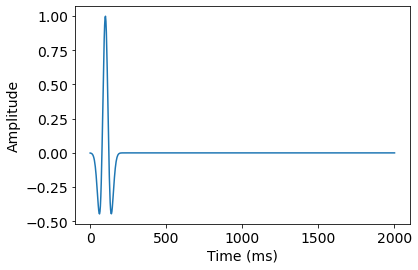

In [8]:
# Source in the center of the model at 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,0] = dx * (nx//2)
src.coordinates.data[0,1] = dz * (nz//2)

# line of receivers along the right edge of the model
rec = Receiver(name='rec', grid=grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:,0] = dx * (nx//2)
rec.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("src_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,0]), np.max(rec.coordinates.data[:,0])))
print("src_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,1]), np.max(rec.coordinates.data[:,1])))

# We can plot the time signature to see the wavelet
src.show()

## Plot velocity and density models

Next we plot the half-space velocity model for illustration. 
- The demarcation between interior and absorbing boundary is shown with a dotted white line
- The source is shown as a large red asterisk
- The extent of the receiver array is shown with a thick dashed blue line

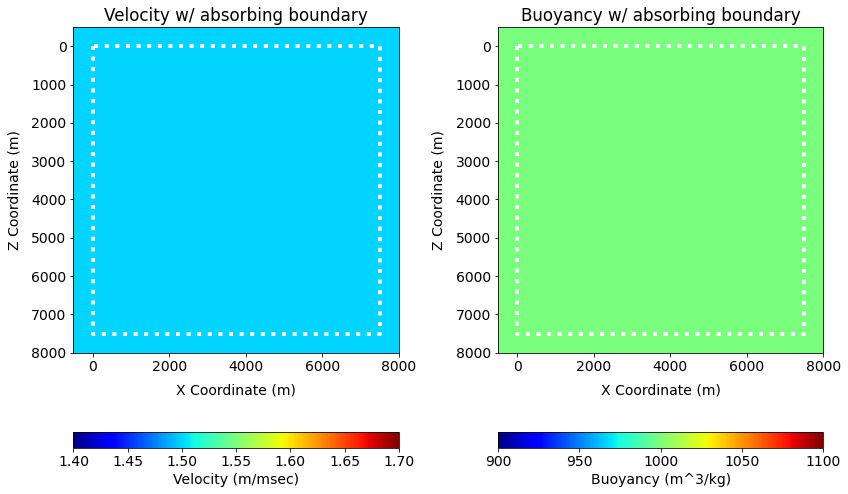

In [9]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + spacing[0]*(shape_pad[0]-1), 
              origin_pad[1] + spacing[1]*(shape_pad[1]-1), origin_pad[1]]

vmin, vmax = 1.4, 1.7
bmin, bmax = 900, 1100

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(m.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Velocity w/ absorbing boundary")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Buoyancy (m^3/kg)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Buoyancy w/ absorbing boundary")

plt.tight_layout()
None

<a id="nl_attenuation"></a>
## Create and plot the $\frac{\omega_c}{Q}$ model used for dissipation only attenuation

We have two remaining constants and fields from our SSA wave equation that we need to define and instantiate:

| &nbsp; Symbol &nbsp; | Description |
| :---: | :--- |
| $$\omega_c = 2 \pi f_c$$      | Center angular frequency |
| $$\frac{1}{Q(x,z)}$$ | Inverse Q model used in the modeling system |

The strategy we use is designed to eliminate any corners or edges in the attentuation profile. We do this by making Q as a function of *distance from the nearest boundary*. 

We have implemented the function ```setup_wOverQ``` for 2D and 3D fields in the file ```utils.py```, and will use it below. In Devito these fields are type ```Function```, a concrete implementation of ```AbstractFunction```. 

Feel free to inspect the source at [utils.py](utils.py). 

Note that we will generate two Q models, one with strong attenuation and one with moderate attenuation -- here Q values of 25 and 100 -- in order to demonstrate the impact of attenuation on the amplitude in the receiver gathers plotted near the end of this notebook. 

Operator `initialize_wOverQ` generated in 0.08 s
  * lowering.IET: 0.04 s (51.8 %)
     * specializing.IET: 0.03 s (38.9 %)
  * lowering.Expressions: 0.03 s (38.9 %)
  * lowering.Clusters: 0.02 s (25.9 %)
     * specializing.Clusters: 0.02 s (25.9 %)
Flops reduction after symbolic optimization: [8 --> 8]
Allocating memory for wOverQ_025(867, 867)


w,fpeak;  0.06283185307179587 0.01


Operator `initialize_wOverQ` jit-compiled `/tmp/devito-jitcache-uid5138/fa43214256f8ad2734f74654837bafed3f0b5742.c` in 0.14 s with `CustomCompiler`
Operator `initialize_wOverQ` run in 0.01 s
* section0<851,851> with OI=2.00 computed in 0.01 s [5.02 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}
Operator `initialize_wOverQ` generated in 0.05 s
  * lowering.IET: 0.03 s (64.9 %)
     * specializing.IET: 0.02 s (43.3 %)
        * optimize_halospots: 0.01 s (21.7 %)
        * make_parallel: 0.01 s (21.7 %)
        * make_simd: 0.01 s (21.7 %)
     * lower_dims: 0.01 s (21.7 %)
     * build: 0.01 s (21.7 %)
  * lowering.Expressions: 0.02 s (43.3 %)
  * lowering.Clusters: 0.01 s (21.7 %)
     * specializing.Clusters: 0.01 s (21.7 %)
        * cire: 0.01 s (21.7 %)
        * blocking: 0.01 s (21.7 %)
        * cse: 0.01 s (21.7 %)
     * analyze: 0.01 s (21.7 %)
     * schedule: 0.01 s (21.7 %)
Flops reduction after symbolic optimization: [8 --> 8]
Allocating memory for wOver

setup_wOverQ_equations ran in 0.2887 seconds -- min/max Q values; 0.1000 24126280183079501824.0000


Operator `initialize_wOverQ` jit-compiled `/tmp/devito-jitcache-uid5138/f172fb2b40f40867cb034528e05779a7bc88556a.c` in 0.14 s with `CustomCompiler`
Operator `initialize_wOverQ` run in 0.01 s
* section0<851,851> with OI=2.00 computed in 0.01 s [4.80 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


setup_wOverQ_equations ran in 0.3252 seconds -- min/max Q values; 0.1000 3162273743318697277128704.0000


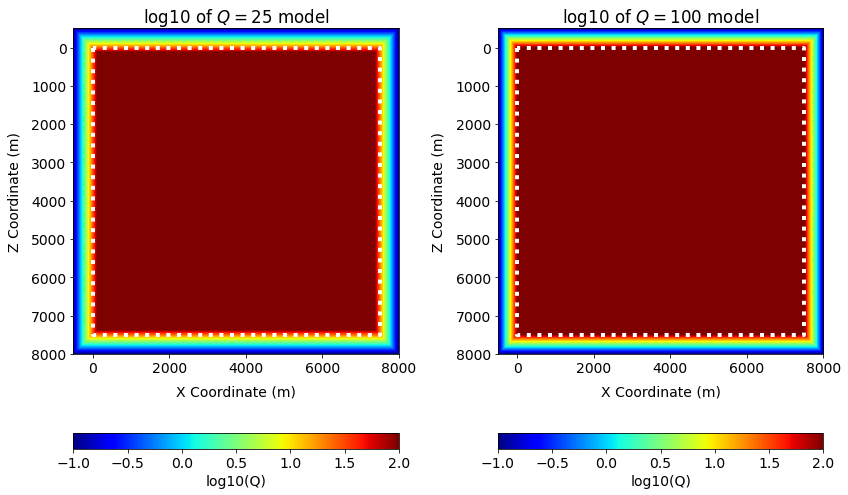

In [10]:
#NBVAL_INGNORE_OUTPUT
# Initialize the attenuation profile for Q=25 and Q=100 models
w = 2.0 * np.pi * fpeak
print("w,fpeak; ", w, fpeak)
qmin = 0.1

wOverQ_025 = Function(name='wOverQ_025', grid=grid, space_order=space_order)
wOverQ_100 = Function(name='wOverQ_100', grid=grid, space_order=space_order)

setup_wOverQ(wOverQ_025, w, qmin, 25.0, npad)
setup_wOverQ(wOverQ_100, w, qmin, 100.0, npad)

# Plot the log of the generated Q profile
q025 = np.log10(w / wOverQ_025.data)
q100 = np.log10(w / wOverQ_100.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(q025.data), cmap=cm.jet, 
           vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("log10 of $Q=25$ model")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(q100.data), cmap=cm.jet,
           vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("log10 of $Q=100$ model")

plt.tight_layout()
None

## Define the pressure wavefield as a ```TimeFunction```

We specify the time_order as 2, which allocates 3 time steps in the pressure wavefield. As described elsewhere, Devito will use "cyclic indexing" to index into this multi-dimensional array. 

This [FAQ entry](https://github.com/devitocodes/devito/wiki/FAQ#as-time-increases-in-the-finite-difference-evolution-are-wavefield-arrays-swapped-as-you-might-see-in-cc-code) explains in more detail.

In [11]:
# Define the TimeFunction
u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

# Get the symbols for dimensions for t, x, z 
# We need these below in order to write the source injection and the
#   time update equation
t,x,z = u.dimensions

## Define the source injection and receiver extraction 

If you examine the equation for the time update we derived above you will see that the source $s$ is scaled by the term $\frac{\delta t^2 m^2}{b}$. You will see that scaling term in the source injection below. For $\delta t^2$ we use ```t.spacing**2```. 

Note that source injection and receiver extraction are accomplished via bi/tri linear interpolation, as implemented in ```SparseTimeFunction``` in [sparse.py](https://github.com/devitocodes/devito/blob/master/devito/types/sparse.py#L747).


In [12]:
# Finally we define the source injection and receiver extraction functions 
src_term = src.inject(field=u.forward, expr=src * t.spacing**2 * m**2 / b)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

<a id="nl_build_operator"></a>
## Finally, the Devito operators

We next transcribe the time update expression above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c++ code for performing the modeling.

We copy the time update expression from above for clarity. Note we omit $s$ from the ```Eq``` below because we will be explicitly injecting the source using ```src_term``` (defined immediately above). However, for the linearized operations *Born modeling* and *Born migration*, the $s$ term is an appropriately scaled field, as shown in the next notebook in this series.  

$$
\begin{aligned}
    u(t+\delta t) &=
        \frac{\delta t^2 m^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + s
        \right] \\[10pt]
        &\quad -\ \frac{\delta t\ \omega_c}{Q} \Bigr[u(t) - u(t-\delta t)\Bigr] 
        + 2 u(t) - u(t-\delta t)
\end{aligned}
$$

In [13]:
#NBVAL_INGNORE_OUTPUT

# Generate the time update equation and operator for Q=25 model
eq_time_update = (t.spacing**2 * m**2 / b) * \
    ((b * u.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) - \
    t.spacing * wOverQ_025 * (u - u.backward) + 2 * u - u.backward

stencil = Eq(u.forward, eq_time_update)

# update the dimension spacing_map to include the time dimension
# these symbols will be replaced with the relevant scalars by the Operator
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# op = Operator([stencil] + src_term + rec_term)
op = Operator([stencil] + src_term + rec_term, subs=spacing_map)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.8}


Operator `Kernel` generated in 1.78 s
  * lowering.Expressions: 1.10 s (61.9 %)
  * lowering.Clusters: 0.40 s (22.5 %)
Flops reduction after symbolic optimization: [298 --> 68]


## Impact of hardwiring the grid spacing on operation count

The argument ```subs=spacing_map``` passed to the operator substitutes values for the ```TimeFunction``` dimensions into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coefficients, and possibly absorbing the spacing scalars from the denominators of the numerical finite difference approximations into the finite difference coefficients.  

If you run the two cases of passing/not passing the ```subs=spacing_map``` argument by commenting/un-commenting the last two lines of the cell immediately above, you can inspect the difference in computed flop count for the operator. Note also if you inspect the generated code for the two cases, you will see extra calling parameters are required for the case without the substitution. We have compiled the flop count from the two runs into the table below.

| Passing subs argument | Flops reduction after symbolic optimization |
|:---|:---:|
| True | 300 --> 68 |
| False | 588 --> 81 |

Note the gain in performance is around 15% for this example in 2D, and would be even more significant in 3D.

In [14]:
# NBVAL_IGNORE_OUTPUT
# Print the arguments used in the signature for the the c++ generated code
op.arguments()

Allocating memory for rec(716, 751)
Allocating memory for u(3, 867, 867)


{'b': <cparam 'P' (0x2b40ac636a70)>,
 'x_m': 0,
 'x_size': 851,
 'x_M': 850,
 'z_m': 0,
 'z_size': 851,
 'z_M': 850,
 'm': <cparam 'P' (0x2b40ac63e5f0)>,
 'o_x': -500.0,
 'o_z': -500.0,
 'rec': <cparam 'P' (0x2b40ac63e930)>,
 'time_m': 1,
 'time_size': 716,
 'time_M': 714,
 'p_rec_m': 0,
 'p_rec_size': 751,
 'p_rec_M': 750,
 'rec_coords': <cparam 'P' (0x2b40ac63dcb0)>,
 'd_m': 0,
 'd_size': 2,
 'd_M': 1,
 'src': <cparam 'P' (0x2b40ac63d2b0)>,
 'p_src_m': 0,
 'p_src_size': 1,
 'p_src_M': 0,
 'src_coords': <cparam 'P' (0x2b40ac63bf30)>,
 'u': <cparam 'P' (0x2b40ac611fb0)>,
 't_size': 3,
 'wOverQ_025': <cparam 'P' (0x2b40ac6115f0)>,
 'nthreads': 16,
 'nthreads_nonaffine': 16,
 'timers': <cparam 'P' (0x2b40ac747af0)>}

In [15]:
# NBVAL_IGNORE_OUTPUT
# Print the generated c++ code
print(op)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict b_vec, struct dataobj *restrict m_vec, const float o_x, const float o_z, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict wOverQ_025_vec, const int x_M, const int x_m, const int x_size, const int z_M, const int z_m, const int z_size, const int p_rec_M, const int p_rec_m, const int p_src_M, const int p_src_m, const int time_M, const int time_m, struct profiler * timers, const int nthreads, const int nthreads_nonaffine)
{
  float (*re

<a id="nl_run_operator"></a>
## Performing the modeling: run the operator for Q=25 and Q=100 models

By setting Devito logging ```configuration['log-level'] = 'DEBUG'``` we have enabled output of statistics related to the performance of the operator, which you will see below when the operator runs.

We will run the Operator once with the Q model as defined ```wOverQ_025```, and then run a second time passing the ```wOverQ_100``` Q model.

In [16]:
#NBVAL_INGNORE_OUTPUT

# run the operator for the Q=25 model
print("m          min/max; %+12.6e %+12.6e" % (np.min(m.data), np.max(m.data)))
print("b          min/max; %+12.6e %+12.6e" % (np.min(b.data), np.max(b.data)))
print("wOverQ_025 min/max; %+12.6e %+12.6e" % (np.min(wOverQ_025.data), np.max(wOverQ_025.data)))
print("wOverQ_100 min/max; %+12.6e %+12.6e" % (np.min(wOverQ_100.data), np.max(wOverQ_100.data)))
print(time_range)
u.data[:] = 0
op(time=time_range.num-1)
# summary = ou(time=time_range.num-1, h_x=dx, h_z=dz, dt=dt)

# save the Q=25 results and run the Q=100 case
import copy
pQ25 = copy.copy(u)
recQ25 = copy.copy(rec)

u.data[:] = 0
op(time=time_range.num-1, wOverQ_025 = wOverQ_100)

print("Q= 25 receiver data min/max; %+12.6e %+12.6e" %\
      (np.min(recQ25.data[:]), np.max(recQ25.data[:])))
print("Q=100 receiver data min/max; %+12.6e %+12.6e" %\
      (np.min(rec.data[:]), np.max(rec.data[:])))

Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/504be3d457dcaff8374da1f8e4cc0a742dd62ba1.c` in 0.01 s from jit-cache


m          min/max; +1.500000e+00 +1.500000e+00
b          min/max; +1.000000e-03 +1.000000e-03
wOverQ_025 min/max; +2.604291e-21 +6.283185e-01
wOverQ_100 min/max; +1.986920e-26 +6.283185e-01
TimeAxis: start=0, stop=2002, step=2.8, num=716


Operator `Kernel` run in 0.49 s
Global performance indicators
  * Achieved 1.07 FD-GPts/s
Local performance indicators
  * section0<<715,858,858>,<715,851,851>> with OI=1.88 computed in 0.46 s [77.50 GFlops/s, 1.14 GPts/s]
  * section1<<715,1>,<715,1>,<715,1>,<715,1>,<715,1>> with OI=3.85 computed in 0.02 s [0.01 GFlops/s, 0.01 GPts/s]
  * section2<<715,751>,<715,751>,<715,751>,<715,751>,<715,751>,<715,751>> with OI=4.84 computed in 0.02 s [2.35 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}
Allocating memory for u(3, 867, 867)
Allocating memory for rec(716, 751)
Allocating memory for rec_coords(751, 2)
Operator `Kernel` run in 0.59 s
Global performance indicators
  * Achieved 0.89 FD-GPts/s
Local performance indicators
  * section0<<715,858,858>,<715,851,851>> with OI=1.88 computed in 0.51 s [70.72 GFlops/s, 1.04 GPts/s]
  * section1<<715,1>,<715,1>,<715,1>,<715,1>,<715,1>> with OI=3.85 computed in 0.05 s [0.01 GFlops/s, 0.01 GPts/s]
  * sec

Q= 25 receiver data min/max; -2.206983e+04 +4.223288e+04
Q=100 receiver data min/max; -2.206983e+04 +4.223288e+04


<a id="nl_plot_wavefield"></a>
## Plot the computed Q=25 and Q=100 wavefields

amax Q= 25;  1633.677368
amax Q=100;  1633.680542


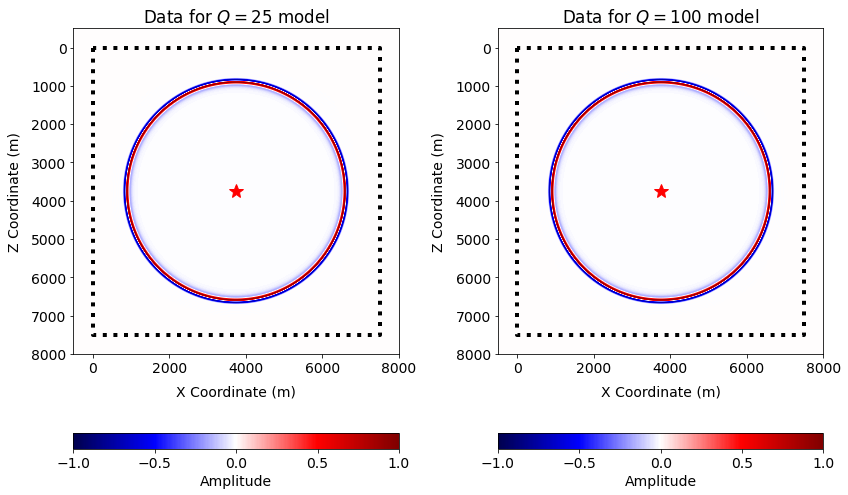

In [17]:
# Plot the two wavefields, normalized to Q=100 (the larger amplitude)
amax_Q25  = 1.0 * np.max(np.abs(pQ25.data[1,:,:]))
amax_Q100 = 1.0 * np.max(np.abs(u.data[1,:,:]))
print("amax Q= 25; %12.6f" % (amax_Q25))
print("amax Q=100; %12.6f" % (amax_Q100))

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(pQ25.data[1,:,:] / amax_Q100), cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Data for $Q=25$ model")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(u.data[1,:,:] / amax_Q100), cmap="seismic",
           vmin=-1, vmax=+1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Data for $Q=100$ model")

plt.tight_layout()
None

## Plot the computed Q=25 and Q=100 receiver gathers

amax Q= 25;  4223.288281
amax Q=100;  4223.288281


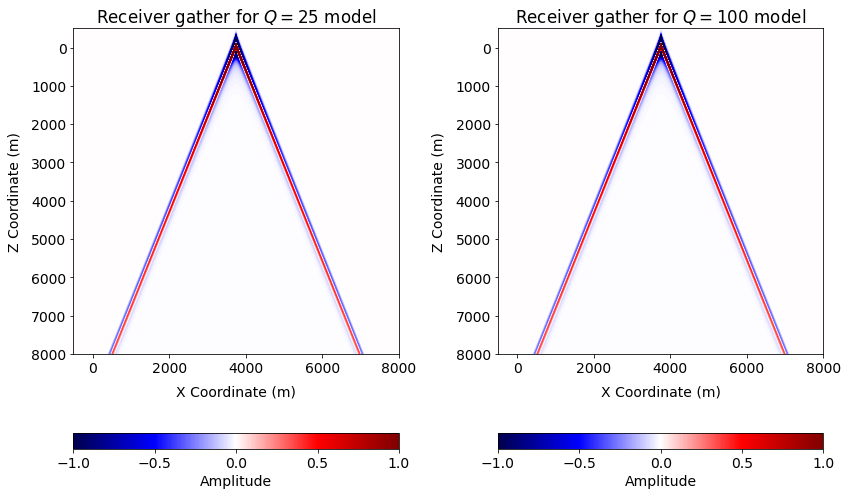

In [18]:
# Plot the two receiver gathers, normalized to Q=100 (the larger amplitude)
amax_Q25  = 0.1 * np.max(np.abs(recQ25.data[:]))
amax_Q100 = 0.1 * np.max(np.abs(rec.data[:]))
print("amax Q= 25; %12.6f" % (amax_Q25))
print("amax Q=100; %12.6f" % (amax_Q100))

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(recQ25.data[:,:] / amax_Q100, cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Receiver gather for $Q=25$ model")

plt.subplot(1, 2, 2)
plt.imshow(rec.data[:,:] / amax_Q100, cmap="seismic",
           vmin=-1, vmax=+1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Receiver gather for $Q=100$ model")

plt.tight_layout()
None

## Show the output from Devito solving for the stencil

Note this takes a **long time** ... about 50 seconds, but obviates the need to solve for the time update expression as we did above.

If you would like to see the time update equation as generated by Devito symbolic optimization, uncomment the lines for the solve below.

In [19]:
#NBVAL_INGNORE_OUTPUT
# Define the partial_differential equation
# Note the backward shifted time derivative is obtained via u.dt(x0=t-0.5*t.spacing) 
pde = (b / m**2) * (wOverQ_100 * u.dt(x0=t-0.5*t.spacing) + u.dt2) -\
        (b * u.dx(x0=x+0.5*x.spacing)).dx(x0=x-0.5*x.spacing) -\
        (b * u.dz(x0=z+0.5*z.spacing)).dz(x0=z-0.5*z.spacing)

# Uncomment the next 5 lines to see the equation as generated by Devito
# t1 = timer()
# stencil = Eq(u.forward, solve(pde, u.forward))
# t2 = timer()
# print("solve ran in %.4f seconds." % (t2-t1)) 
# stencil

<a id="nl_refs"></a>
## References
<br>

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1
<br>

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf
<br>

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
